# Just-in-time Compilation with [Numba](http://numba.pydata.org/) 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import numba

## Using `numba.jit`

Numba offers `jit` which can used to decorate Python functions.

In [2]:
def is_prime(n):
    if n <= 1:
        raise ArithmeticError('"%s" <= 1' % n)
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False
            
    return True

In [3]:
n = np.random.randint(2, 10000000, dtype=np.int64) # Get a random integer between 2 and 10000000
print(n, is_prime(n))

2094955 False


In [4]:
#is_prime(1)

In [5]:
@numba.jit(forceobj=True)
def is_prime_jitted(n):
    if n <= 1:
        raise ArithmeticError('"%s" <= 1' % n)
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False

    return True

In [6]:
numbers = np.random.randint(2, 100000, dtype=np.int64, size=10000)
%time p1 = [is_prime(n) for n in numbers]
%time p2 = [is_prime_jitted(n) for n in numbers]

CPU times: user 37.6 ms, sys: 229 µs, total: 37.9 ms
Wall time: 36.8 ms
CPU times: user 1.26 s, sys: 206 ms, total: 1.47 s
Wall time: 2.4 s


## Using ` @numba.jit(nopython=True)` is equivalent to using ` @numba.njit`

In [8]:
@numba.njit
def is_prime_njitted(n):
    if n <= 1:
        raise ArithmeticError('n <= 1')
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False

    return True

In [9]:
numbers = np.random.randint(2, 100000, dtype=np.int64, size=1000)
%time p = [is_prime_njitted(n) for n in numbers]
%time p = [is_prime_njitted(n) for n in numbers]

CPU times: user 126 ms, sys: 8.31 ms, total: 134 ms
Wall time: 139 ms
CPU times: user 511 µs, sys: 0 ns, total: 511 µs
Wall time: 515 µs


## Use `cache=True` to cache the compiled function

In [10]:
import math
from numba import njit

@njit(cache=True)
def is_prime_njitted_cached(n):
    if n <= 1:
        raise ArithmeticError('n <= 1')
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False

    return True

In [11]:
numbers = np.random.randint(2, 100000, dtype=np.int64, size=1000)
%time p = [is_prime_njitted_cached(n) for n in numbers]
%time p = [is_prime_njitted_cached(n) for n in numbers]

CPU times: user 133 ms, sys: 48 µs, total: 133 ms
Wall time: 200 ms
CPU times: user 423 µs, sys: 84 µs, total: 507 µs
Wall time: 510 µs


## Eager compilation using function signatures

In [12]:
import math
from numba import njit

@njit(['boolean(int64)', 'boolean(int32)'])
def is_prime_njitted_eager(n):
    if n <= 1:
        raise ArithmeticError('n <= 1')
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False

    return True

In [13]:
numbers = np.random.randint(2, 1000000, dtype=np.int64, size=1000)
%time p1 = [is_prime_njitted_eager(n) for n in numbers]
%time p2 = [is_prime_njitted_eager(n) for n in numbers]

CPU times: user 635 µs, sys: 115 µs, total: 750 µs
Wall time: 754 µs
CPU times: user 616 µs, sys: 112 µs, total: 728 µs
Wall time: 732 µs


In [14]:
p1 = [is_prime_njitted_eager(n) for n in numbers.astype(np.int32)]
#p2 = [is_prime_njitted_eager(n) for n in numbers.astype(np.float64)]

# Using `numba.jit` to speedup the computation of the Euclidean distance matrix 

In this notebook we implement a function to compute the Euclidean distance matrix using Numba's *just-in-time* compilation decorator. We compare it with the NumPy function we wrote before.

We will use two Numba functions here: The decorator ` @numba.jit` and `numba.prange`.

In [15]:
import numpy as np
import numba

In [16]:
@numba.jit(nopython=True)
def euclidean_numba1(x, y):
    """Euclidean square distance matrix using pure loops
    and no NumPy operations
    """
    num_samples, num_feat = x.shape
    dist_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(num_samples):
            r = 0.0
            for k in numba.prange(num_feat):
                r += (x[i][k] - y[j][k])**2
            dist_matrix[i][j] = r

    return dist_matrix

@numba.jit(nopython=True)
def euclidean_numba2(x, y):
    """Euclidean square distance matrix using loops
    and the `numpy.dot` operation
    """
    num_samples, num_feat = x.shape
    dist_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in numba.prange(num_samples):
            dist_matrix[i][j] = ((x[i] - y[j])**2).sum()

    return dist_matrix

Let's include here our numpy implementation for comparison.

In [17]:
def euclidean_numpy(x, y):
    """Euclidean square distance matrix using numpy"""
    x2 = np.einsum('ij,ij->i', x, x)[:, np.newaxis]
    y2 = np.einsum('ij,ij->i', y, y)[:, np.newaxis].T
    xy = np.dot(x, y.T)
    return np.abs(x2 + y2 - 2. * xy)

### Note
Observe that we do the inner loop, which is a reduction, with `numba.prange`. `numba.prange` automatically takes care of data privatization and reductions.

### Exercise 1
Before runing the different functions, could you say which of the two numba implementations would be faster?

In [18]:
# Let's check that they all give the same result
a = 10. * np.random.random([100, 10])

print(np.abs(euclidean_numpy(a, a) - euclidean_numba1(a, a)).max())
print(np.abs(euclidean_numpy(a, a) - euclidean_numba2(a, a)).max())

3.410605131648481e-13
3.410605131648481e-13


Our Numba implementations can be faster than the NumPy one for a list of small vectors. However, with larger vectors, the NumPy implementation is faster:

In [19]:
nsamples = 100
nfeat = 3

x = 10. * np.random.random([nsamples, nfeat])

%timeit euclidean_numpy(x, x)
%timeit euclidean_numba1(x, x)
%timeit euclidean_numba2(x, x)

162 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
36.4 µs ± 45.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.11 ms ± 3.37 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [20]:
nsamples = 100
nfeat = 50

x = 10. * np.random.random([nsamples, nfeat])

%timeit euclidean_numpy(x, x)
%timeit euclidean_numba1(x, x)
%timeit euclidean_numba2(x, x)

160 µs ± 31 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
411 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.62 ms ± 2.44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In a more realistic case, our NumPy implementation is much faster:

In [21]:
nsamples = 5000
nfeat = 50

x = 10. * np.random.random([nsamples, nfeat])

%timeit euclidean_numpy(x, x)
%timeit euclidean_numba1(x, x)

444 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.07 s ± 5.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Calculating and plotting the [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set)

In [22]:
X, Y = np.meshgrid(np.linspace(-2.0, 1, 1000), np.linspace(-1.0, 1.0, 1000))

def mandelbrot(X, Y, itermax):
    mandel = np.empty(shape=X.shape, dtype=np.int32)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            it = 0
            cx = X[i, j]
            cy = Y[i, j]
            x = 0.0
            y = 0.0
            while x * x + y * y < 4.0 and it < itermax:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                it += 1
            mandel[i, j] = it
            
    return mandel

CPU times: user 22 s, sys: 2.93 ms, total: 22 s
Wall time: 22 s


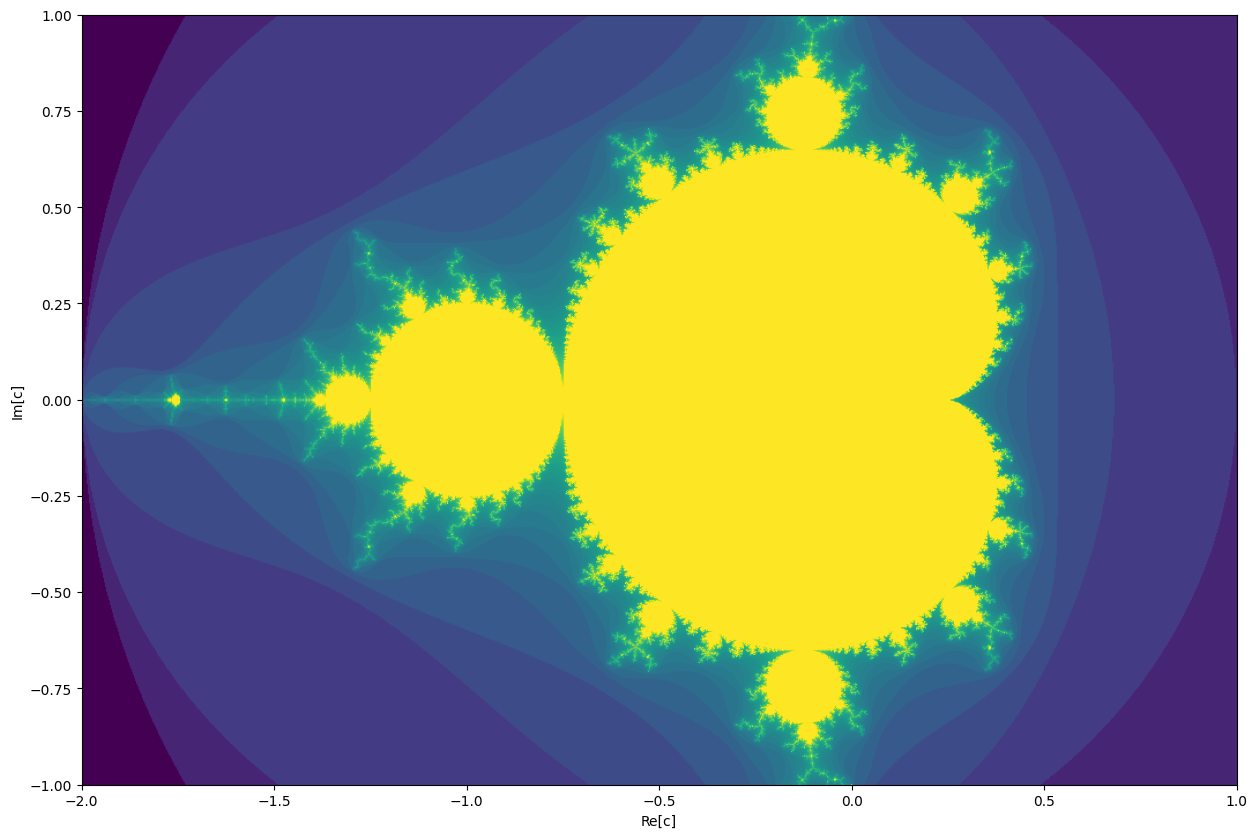

In [23]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

%time m = mandelbrot(X, Y, 100)
    
ax.imshow(np.log(1 + m), extent=[-2.0, 1, -1.0, 1.0]);
ax.set_aspect('equal')
ax.set_ylabel('Im[c]')
ax.set_xlabel('Re[c]');

In [1]:
@numba.njit(parallel=True)
def mandelbrot_jitted(X, Y, radius2, itermax):
    mandel = np.empty(shape=X.shape, dtype=np.int32)
    for i in numba.prange(X.shape[0]):
        for j in range(X.shape[1]):
            it = 0
            cx = X[i, j]
            cy = Y[i, j]
            x = cx
            y = cy
            while x * x + y * y < 4.0 and it < itermax:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                it += 1
            mandel[i, j] = it
            
    return mandel

NameError: name 'numba' is not defined

CPU times: user 773 ms, sys: 23 ms, total: 796 ms
Wall time: 871 ms


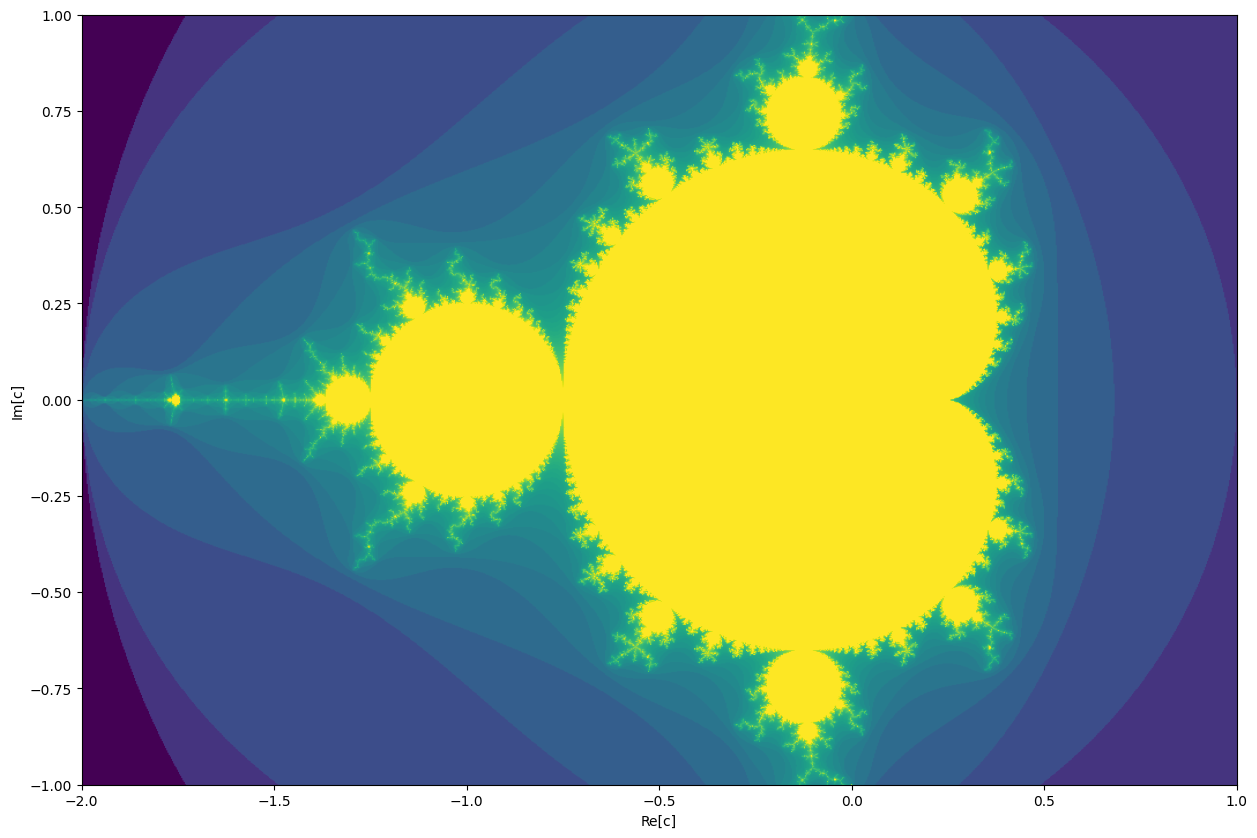

In [25]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)


%time m = mandelbrot_jitted(X, Y, 4.0, 100)
    
ax.imshow(np.log(1 + m), extent=[-2.0, 1, -1.0, 1.0]);
ax.set_aspect('equal')
ax.set_ylabel('Im[c]')
ax.set_xlabel('Re[c]');

### Getting parallelization information

In [26]:
mandelbrot_jitted.parallel_diagnostics(level=3)

 
 Parallel Accelerator Optimizing:  Function mandelbrot_jitted, 
/scr/13306566.1.all.q/ipykernel_14040/2504093024.py (1)  


Parallel loop listing for  Function mandelbrot_jitted, /scr/13306566.1.all.q/ipykernel_14040/2504093024.py (1) 
---------------------------------------------------------------|loop #ID
@numba.njit(parallel=True)                                     | 
def mandelbrot_jitted(X, Y, radius2, itermax):                 | 
    mandel = np.empty(shape=X.shape, dtype=np.int32)           | 
    for i in numba.prange(X.shape[0]):-------------------------| #0
        for j in range(X.shape[1]):                            | 
            it = 0                                             | 
            cx = X[i, j]                                       | 
            cy = Y[i, j]                                       | 
            x = cx                                             | 
            y = cy                                             | 
            while x * x + y

## Creating `ufuncs` using `numba.vectorize`

In [27]:
from math import sin
from numba import float64, int64

def my_numpy_sin(a, b):
    return np.sin(a) + np.sin(b)

@np.vectorize
def my_sin(a, b):
    return sin(a) + sin(b)

@numba.vectorize([float64(float64, float64), int64(int64, int64)], target='parallel')
def my_sin_numba(a, b):
    return np.sin(a) + np.sin(b)

In [28]:
x = np.random.randint(0, 100, size=9000000)
y = np.random.randint(0, 100, size=9000000)

%time _ = my_numpy_sin(x, y)
%time _ = my_sin(x, y)
%time _ = my_sin_numba(x, y)

CPU times: user 729 ms, sys: 20.5 ms, total: 750 ms
Wall time: 750 ms
CPU times: user 3.88 s, sys: 208 ms, total: 4.09 s
Wall time: 4.09 s
CPU times: user 175 ms, sys: 15.8 ms, total: 191 ms
Wall time: 49.1 ms


### Vectorize the testing of prime numbers 

In [29]:
@numba.vectorize('boolean(int64)')
def is_prime_v(n):
    if n <= 1:
        raise ArithmeticError(f'"0" <= 1')
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False
            
    return True

In [30]:
numbers = np.random.randint(2, 10000000000, dtype=np.int64, size=100000)
%time p = is_prime_v(numbers)

CPU times: user 3.14 s, sys: 0 ns, total: 3.14 s
Wall time: 3.15 s


### Parallelize the vectorized function

In [31]:
@numba.vectorize(['boolean(int64)', 'boolean(int32)'],
                 target='parallel')
def is_prime_vp(n):
    if n <= 1:
        raise ArithmeticError('n <= 1')
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False
            
    return True

In [32]:
numbers = np.random.randint(2, 10000000000, dtype=np.int64, size=100000)
%time p1 = is_prime_v(numbers)
%time p2 = is_prime_vp(numbers)

CPU times: user 3.06 s, sys: 0 ns, total: 3.06 s
Wall time: 3.06 s
CPU times: user 5.1 s, sys: 0 ns, total: 5.1 s
Wall time: 1.28 s


In [33]:
# Print the largest primes from to 1 and 10 millions
numbers = np.arange(1000000, 10000001, dtype=np.int32)
%time p1 = is_prime_vp(numbers)
primes = numbers[p1]

for n in primes[-10:]:
    print(n)

CPU times: user 12.8 s, sys: 4.99 ms, total: 12.8 s
Wall time: 3.19 s
9999889
9999901
9999907
9999929
9999931
9999937
9999943
9999971
9999973
9999991


# Creating Generalized Ufuncs with Numba

Numba offers the `guvectorize` to generate **generalized ufuncs** which work of input arrays with different dimensions.

In [34]:
import numpy as np
import numba

## Adding a constant to a vector

In [35]:
@numba.guvectorize(['(f8[:], f8[:], f8[:])'], '(m),()->(m)')
def vec_add_const(x, y, z):
    for i in range(x.shape[0]):
        z[i] = x[i] + y[0]

In [36]:
x = np.arange(10.0)
z = vec_add_const(x, 2.0)
print(x, z, sep='\n')

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


In [37]:
x = np.arange(10.0).reshape(2, 5)
z = vec_add_const(x, 2.0)
print(x, z, sep='\n')

[[0. 1. 2. 3. 4.]
 [5. 6. 7. 8. 9.]]
[[ 2.  3.  4.  5.  6.]
 [ 7.  8.  9. 10. 11.]]


In [38]:
x = np.arange(10.0).reshape(2, 5)
y = np.array([1., 2.])
z = vec_add_const(x, y)
print(x, z, sep='\n')

[[0. 1. 2. 3. 4.]
 [5. 6. 7. 8. 9.]]
[[ 1.  2.  3.  4.  5.]
 [ 7.  8.  9. 10. 11.]]


## Matrix Vector Multiplication

In [39]:
@numba.guvectorize(['(f8[:, :], f8[:], f8[:])'], '(m,n),(n)->(m)')
def mat_vec_mult(x, y, z):
    for i in range(x.shape[0]):
        d = 0.0
        for j in range(x.shape[1]):
            d += x[i, j] * y[j]
        z[i] = d

In [40]:
A = np.arange(9.0).reshape(3, 3)
x = np.array([1., 2., 3.])
z = mat_vec_mult(A, x)
print(A, z, sep='\n\n')

[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]

[ 8. 26. 44.]


In [41]:
A = np.arange(27.0).reshape(3, 3, 3)
x = np.array([1., 2., 3])
z = mat_vec_mult(A, x)
print(A, z, sep='\n\n')

[[[ 0.  1.  2.]
  [ 3.  4.  5.]
  [ 6.  7.  8.]]

 [[ 9. 10. 11.]
  [12. 13. 14.]
  [15. 16. 17.]]

 [[18. 19. 20.]
  [21. 22. 23.]
  [24. 25. 26.]]]

[[  8.  26.  44.]
 [ 62.  80.  98.]
 [116. 134. 152.]]


## Matrix-Matrix Multiplication

In [42]:
@numba.guvectorize(['(f8[:, :], f8[:, :], f8[:, :])'], '(m,n),(n,k)->(m, k)')
def mat_mul(x, y, z):
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            d = 0.0
            for k in range(x.shape[1]):
                d += x[i, k] * y[k, j]
            z[i, j] = d

In [43]:
A = np.arange(9.0).reshape(3, 3)
B = np.arange(9.0, 24.0).reshape(3, 5)
C = mat_mul(A, B)
C_numpy = A @ B
print(C, C_numpy, sep='\n\n')
numba.guvectorize?

[[ 52.  55.  58.  61.  64.]
 [178. 190. 202. 214. 226.]
 [304. 325. 346. 367. 388.]]

[[ 52.  55.  58.  61.  64.]
 [178. 190. 202. 214. 226.]
 [304. 325. 346. 367. 388.]]


Signature: numba.guvectorize(*args, **kwargs)
Docstring:
guvectorize(ftylist, signature, target='cpu', identity=None, **kws)

A decorator to create NumPy generalized-ufunc object from Numba compiled
code.

Args
-----
ftylist: iterable
    An iterable of type signatures, which are either
    function type object or a string describing the
    function type.

signature: str
    A NumPy generalized-ufunc signature.
    e.g. "(m, n), (n, p)->(m, p)"

identity: int, str, or None
    The identity (or unit) value for the element-wise function
    being implemented.  Allowed values are None (the default), 0, 1,
    and "reorderable".

cache: bool
    Turns on caching.

writable_args: tuple
    a tuple of indices of input variables that are writable.

target: str
        A string for code generation target.  Defaults to "cpu".

Returns
--------

A NumPy generalized universal-function

Example
-------
    @guvectorize(['void(int32[:,:], int32[:,:], int32[:,:])',
                  'void(float32[: